In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

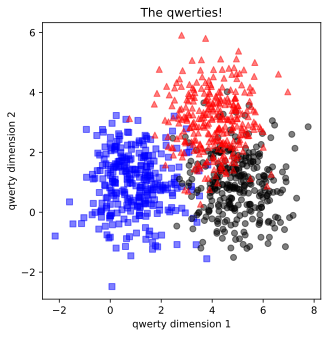

In [18]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [19]:
# partiotion sizes for dev, devset and test sets, in that order
partitions = [3*nPerClust-400, 200, 200]

# split the data
train_data, devtest_data, train_labels, devtest_lables = train_test_split(data, labels, train_size=partitions[0])

# split the devtest data
dev_data, test_data, dev_labels, test_labels = train_test_split(devtest_data, devtest_lables, train_size=partitions[1])

print('Total data size: ' + str(data.shape))
print('Train data size: ' + str(train_data.shape))
print('Devset data size: ' + str(dev_data.shape))
print('Test data size: ' + str(test_data.shape))

Total data size: torch.Size([900, 2])
Train data size: torch.Size([500, 2])
Devset data size: torch.Size([200, 2])
Test data size: torch.Size([200, 2])


In [20]:
train_dataT = TensorDataset(train_data, train_labels)
dev_dataT = TensorDataset(dev_data, dev_labels)
test_dataT = TensorDataset(test_data, test_labels)

batch_size = 30
train_dl = DataLoader(train_dataT, batch_size=batch_size, shuffle=True, drop_last=True)
dev_dl = DataLoader(dev_dataT, batch_size=dev_dataT.tensors[0].shape[0])
test_dl = DataLoader(test_dataT, batch_size=test_dataT.tensors[0].shape[0])

In [21]:
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 8)
        self.hidden = nn.Linear(8, 8)
        self.output = nn.Linear(8, 3)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.hidden(x))
        x = self.output(x)

        return x

In [22]:
def getModel():
    ANN = model()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr = 0.01)
    return ANN, lossFunction, optimizer

In [23]:
epochs = 100

def trainModel(ANN, lossFunction, optimizer):

    # Dictionary for the best model
    theBestModel = {'Accuracy': 0, 'net': None}

    losses = torch.zeros(epochs)
    trainAcc = []
    devAcc = []

    for _ in range(epochs):

        ANN.train()

        batchAcc = []
        batchLoss = []

        for x, y in train_dl:
            yHat = ANN.forward(x)

            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)
        
        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        ANN.eval()

        X, Y = next(iter(dev_dl))
        with torch.no_grad():
            pred = ANN(X)
        
        devAcc.append(torch.mean(((torch.argmax(pred, axis=1))==Y).float())*100)

        # save the best model
        if devAcc[-1] > theBestModel['Accuracy']:
            theBestModel['Accuracy'] = devAcc[-1].item()
            theBestModel['net'] = copy.deepcopy(ANN.state_dict())
    
    return trainAcc, devAcc, losses, theBestModel

In [24]:
ANN, lossFunction, optimizer = getModel()
trainAcc, devAcc, losses, theBestModel = trainModel(ANN, lossFunction, optimizer)

In [25]:
theBestModel

{'Accuracy': 90.0,
 'net': OrderedDict([('input.weight',
               tensor([[ 0.4075,  0.3514],
                       [-0.1364,  0.4973],
                       [ 0.7705,  0.5308],
                       [ 0.2427,  0.7485],
                       [ 0.3427, -0.5547],
                       [-0.3396, -0.5466],
                       [ 0.8312, -0.6462],
                       [-0.2951, -0.6067]])),
              ('input.bias',
               tensor([-0.4487,  0.8595, -0.5449, -0.0487,  0.6693, -0.0504,  0.1476, -0.2535])),
              ('hidden.weight',
               tensor([[ 0.1641, -0.2156,  0.8102,  0.2524,  0.0016,  0.2112,  0.4007,  0.0356],
                       [ 0.2784,  0.6166,  0.0974,  0.1552, -0.1962, -0.1683, -0.2541, -0.0218],
                       [ 0.3091, -0.2451,  0.4158,  0.2353, -0.1146,  0.0641, -0.1420, -0.2825],
                       [ 0.1580,  0.0666, -0.2620, -0.3278,  0.1908,  0.2891, -0.1348,  0.2236],
                       [-0.3641, -0.0271,  0.1712

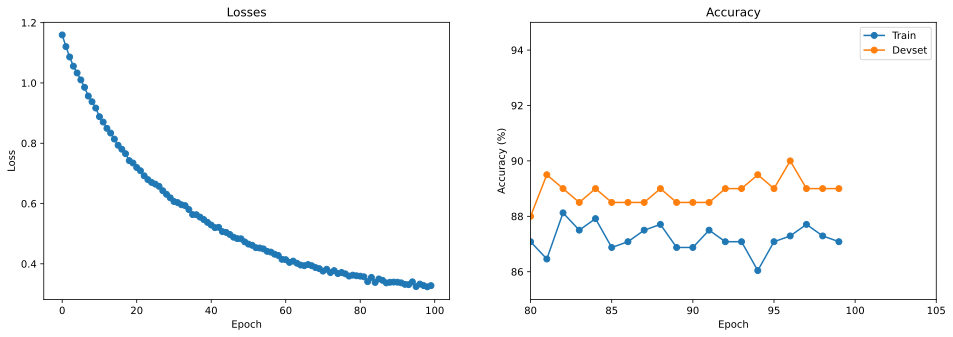

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses.detach(), 'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, 'o-', label = 'Train')
ax[1].plot(devAcc, 'o-', label = 'Devset')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].set_ylim([85, 95])
ax[1].set_xlim([80, 105])
ax[1].legend()
plt.show()

In [33]:
# recreate the best performing model

bestNet = getModel()[0]
bestNet.load_state_dict(theBestModel['net'])

# Test Dataloader

X, Y = next(iter(test_dl))
Pred = bestNet(X)

bestNetAcc = torch.mean((torch.argmax(Pred, axis=1)==Y).float())*100
bestNetAcc


tensor(89.)

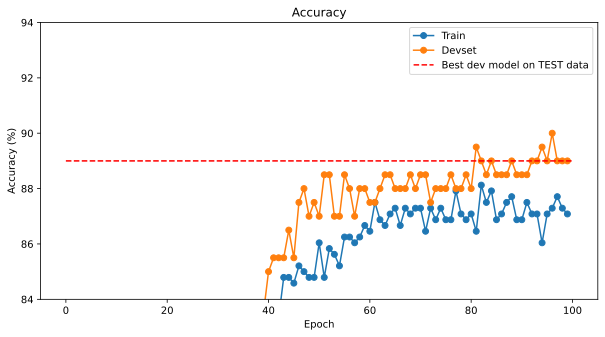

In [36]:
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, 'o-', label='Train')
plt.plot(devAcc, 'o-', label='Devset')
plt.plot([0, len(devAcc)], [bestNetAcc, bestNetAcc], 'r--', label='Best dev model on TEST data')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.ylim([bestNetAcc-5, bestNetAcc+5])
plt.legend()
plt.show()

### Saving and Loading Model

In [40]:
torch.save(bestNet.state_dict(), '../00-Saved Models/06-02.pt')

In [41]:
loadedModel = getModel()[0]
loadedModel.load_state_dict(torch.load('../00-Saved Models/06-02.pt'))
loadedModel

model(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (hidden): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)